<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 7 - Modelos de Ensambles - Xgboost y LightGBM </h3>
    <h3>Ejercicio 2A_Sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.


**Objetivo del Ejercicio**:  
Nos centraremos en el problema del consumo de energía, donde, dado un conjunto de datos suficientemente grande del consumo diario de energía de diferentes hogares en una ciudad, tenemos la tarea de predecir con la mayor precisión posible las demandas energéticas futuras.  

El dataset contiene el consumo de energía de 5.567 hogares seleccionados al azar en la ciudad de Londres durante el período comprendido entre noviembre de 2011 y febrero de 2014.  

Nota: Como queremos predecir el consumo de forma general y no por hogar, debemos agrupar los resultados por fecha y promediar los kilovatios-hora.

FUENTE DEL DATASET: https://www.kaggle.com/datasets/emmanuelfwerr/london-homes-energy-data

Carga de Librerías

In [ ]:
import pandas as pd
import requests
from io import BytesIO
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

In [ ]:
# URL del archivo ZIP en GitHub
zip_url = 'https://github.com/braiandrago/AST/blob/main/london_energy.csv.zip?raw=true'

# Descargar el archivo ZIP
response = requests.get(zip_url)
if response.status_code == 200:
    # Leer el contenido del archivo ZIP en un objeto BytesIO
    zip_content = BytesIO(response.content)

    # Descomprimir el archivo ZIP y extraer el archivo CSV
    with zipfile.ZipFile(zip_content, 'r') as zip_file:
        # Supongamos que el archivo CSV dentro del ZIP se llama 'archivo.csv'
        csv_file_name = 'london_energy.csv'
        with zip_file.open(csv_file_name) as csv_file:
            # Leer el archivo CSV en un DataFrame
            df = pd.read_csv(csv_file)

    # Mostrar la información del DataFrame
    df.info()
else:
    print("Error al descargar el archivo ZIP")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   LCLid   object 
 1   Date    object 
 2   KWH     float64
dtypes: float64(1), object(2)
memory usage: 80.3+ MB


`LCLid` es una cadena única que identifica a cada hogar.   
`Date` variable tiempo.  
`KWH` es el número total de kilovatios-hora gastados en esa fecha y no falta ningún valor.

# Carga y Procesamiento inicial del dataset

In [ ]:
df.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [ ]:
print(df.isna().sum())

LCLid    0
Date     0
KWH      0
dtype: int64


In [ ]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


In [ ]:
df_avg_consumption.head()

,date,consumption
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805


In [ ]:
df_avg_consumption.tail()

,date,consumption
824,2014-02-24,10.411403
825,2014-02-25,10.294997
826,2014-02-26,10.202945
827,2014-02-27,10.356350
828,2014-02-28,0.417993


<Axes: xlabel='date'>

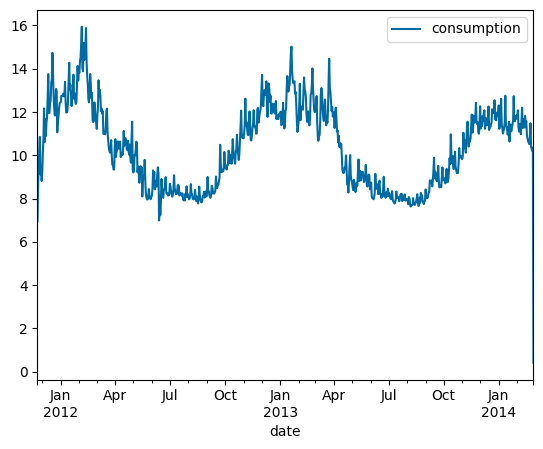

In [ ]:
df_avg_consumption.plot(x="date", y="consumption")

Estacionalidad:

<Axes: xlabel='date'>

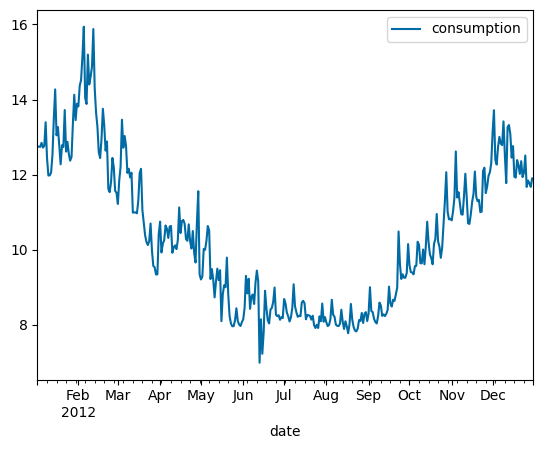

In [ ]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")

**Feature Enginering**

De manera similar a los ejercicios anteriores....Para entrenar un modelo como XGBoost y LightGB necesitamos crear las funciones nosotros mismos. Actualmente, solo tenemos una característica: la fecha completa. Podemos extraer diferentes características en función de la fecha completa como el día de la semana, el día del año, el mes y otros.

In [ ]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


**Separación de los datos para el modelado:**

Hasta aqui... date no fue tratada como index. Podemos utilizarla para separar los datos y luego eliminarla.

Para el conjunto de pruebas usaremos solo los últimos 6 meses. Si el conjunto de entrenamiento fuera más grande, habríamos utilizado todo el último año como conjunto de pruebas.

In [ ]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 7)
(216, 7)


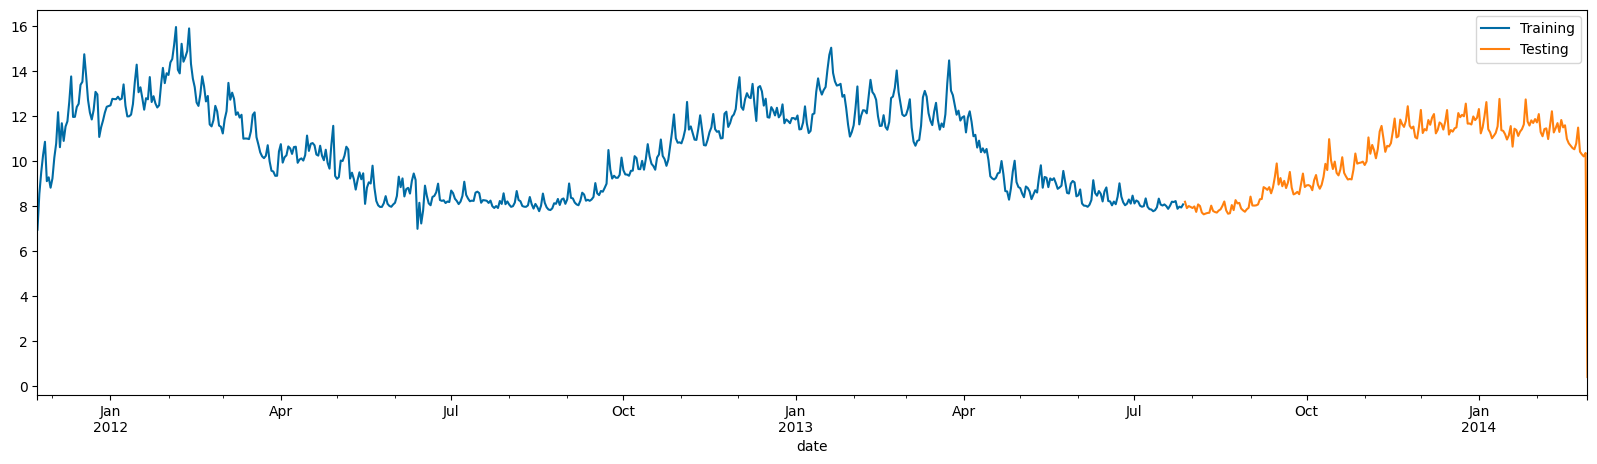

In [ ]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [ ]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

**Entrenamiento del modelo:**

La optimización de los hiperparámetros se realizará con gridsearch, la cual toma parámetros y algunos valores como configuración y prueba todas las combinaciones posibles.

Nuevamente, debido a la naturaleza del problema, no podemos simplemente usar una validación cruzada simple de k veces. Scikit learn proporciona el método TimeSeriesSplit que divide los datos de forma incremental de manera respetuosa en términos de continuidad.

**Para Xgboost:**

In [ ]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

**Evaluación**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

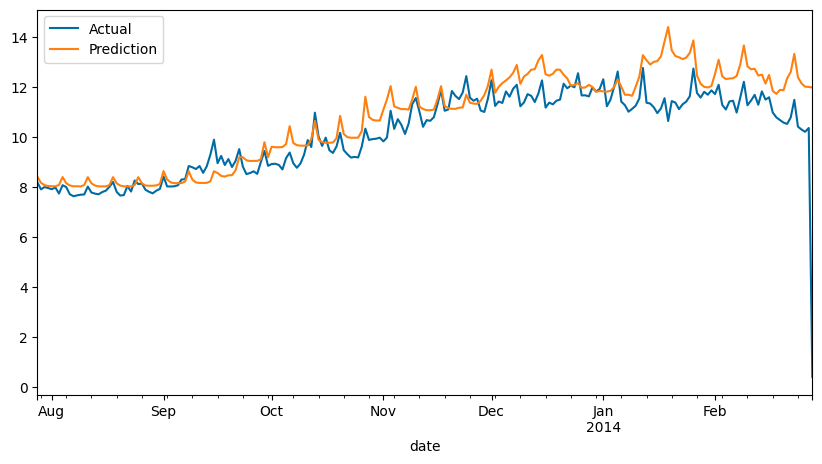

MAE: 0.7330404137119078
MSE: 1.3902031538115365
MAPE: 0.1929515940113626


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Y para LighGBM**

In [ ]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

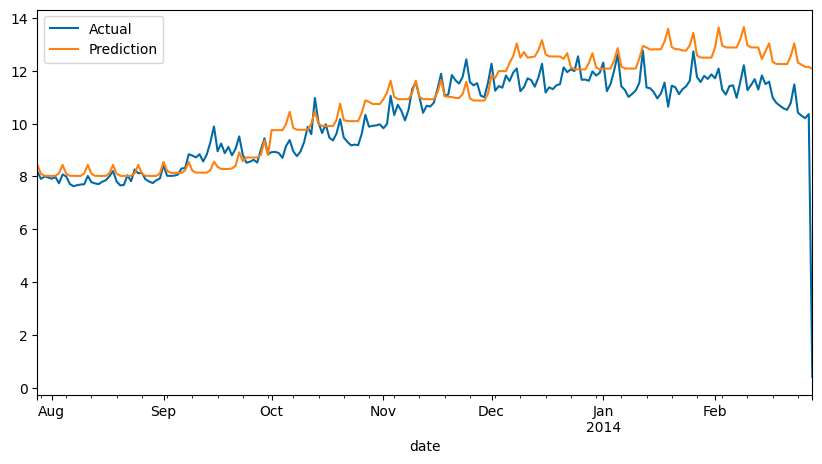

MAE: 0.7598511155488689
MSE: 1.4174602236853142
MAPE: 0.19624274959783336


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Cómo mejoramos el rendimiento de los modelos?**

Utilizararemos funciones auxiliares que estén correlacionadas directa o indirectamente con el consumo de energía. Como por ejemplo datos del servicio meteorologico de Londres:

Fuente del dataset:https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023

In [ ]:
url = 'https://raw.githubusercontent.com/braiandrago/AST/main/london_weather.csv'
df_weather = pd.read_csv(url)
print(df_weather.isna().sum())
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


Hay varios datos faltantes que es necesario completar. Como tenemos datos meteorológicos en los que cada día depende del día anterior y del siguiente, completaremos esos valores interpolando. Además, convertiremos la columna "fecha" a "fecha y hora" y, luego, fusionaremos los dos datasets para obtener uno mejorado.

In [ ]:
# Parsing dates
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

# Filling missing values through interpolation
df_weather = df_weather.interpolate(method="ffill")

# Enhancing consumption dataset with weather information
df_avg_consumption = df_avg_consumption.merge(df_weather, how="inner", on="date")
df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,2,327,11,4,2011,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,3,328,11,4,2011,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,4,329,11,4,2011,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,5,330,11,4,2011,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,6,331,11,4,2011,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


**Separación de los datos del nuevo dataset:**

In [ ]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 16)
(216, 16)


In [ ]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_train = training_data["consumption"]


X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_test = testing_data["consumption"]

**Entrenamiento**

In [ ]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

**Evaluación**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

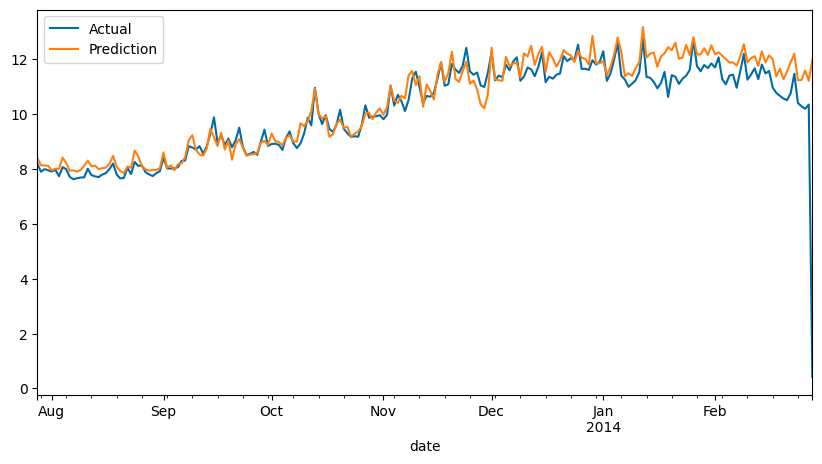

MAE: 0.41222399123657294
MSE: 0.8432288584575132
MAPE: 0.16246850639888177


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

**Para LightGBM**

In [ ]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

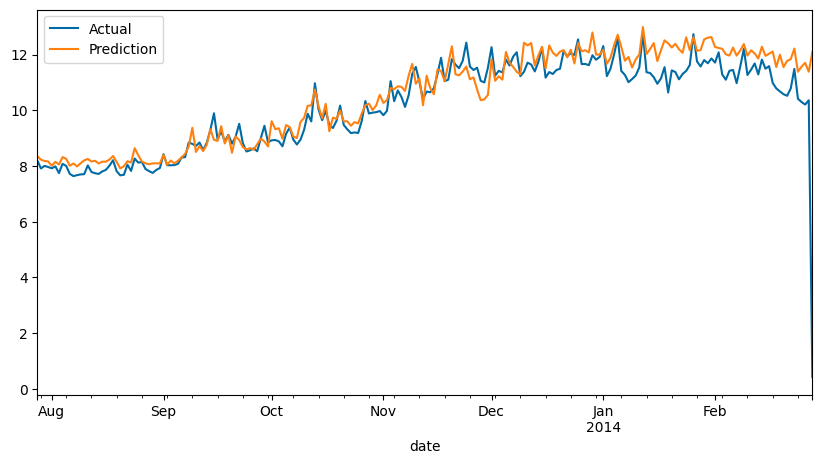

MAE: 0.476487191053889
MSE: 0.9170412738351784
MAPE: 0.16983133657848068


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)